In [1]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy import create_engine, MetaData, inspect
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import Column, Integer, String, Numeric, Text, Float, Date, func
from sqlalchemy.ext.automap import automap_base as automap_base_HM
from sqlalchemy.ext.automap import automap_base as automap_base_HS
from sqlalchemy.orm import Session
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [2]:
# Create an engine to database 
engine_HM = create_engine("sqlite:///cleaned_Hawaii_Measurements.sqlite")
engine_HS = create_engine("sqlite:///cleaned_Hawaii_Stations.sqlite")

In [3]:
conn_HM = engine_HM.connect()
conn_HS = engine_HS.connect()

In [4]:
#Reflecting into tables:
#Objects inheriting the automap base class
#If only one Base object calls the prepare method for two separate engines, then a SAWarning will be produced
#So we are instantializing two separate objects to workaround it.
Base_HM = automap_base_HM()
Base_HS = automap_base_HS()


#AutomapBase.prepare() method is called on the object to asking it to reflect the schema and produce mappings
Base_HM.prepare(engine_HM,reflect=True) 
Base_HS.prepare(engine_HS,reflect=True) 


In [5]:
Base_HS.classes.keys()
HM = Base_HM.classes.Measurement
HS = Base_HS.classes.Station

In [6]:
measurement = Base_HM.classes.keys()
station = Base_HS.classes.keys()

In [7]:
session_HM = Session(engine_HM)
session_HS = Session(engine_HS)

In [38]:
engine_HM.execute('SELECT date,prcp FROM Measurement WHERE date >= "2016-08-23"').fetchall()

In [9]:
date_prcp = engine_HM.execute('SELECT date,prcp FROM Measurement WHERE date >= "2016-08-23"').fetchall()
dates = []
prcps = []
for i in date_prcp:
    dates.append(i[0])
    prcps.append(i[1])

In [39]:
analysis_1 = pd.DataFrame({"Dates":dates,"Prcp":prcps})
analysis_1["Prcp"].fillna(value = 0)

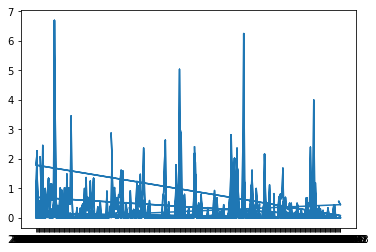

In [11]:
x = analysis_1["Dates"]
y = analysis_1["Prcp"]
plt.plot(x,y)
plt.show()

In [12]:
#Total number of stations
stations_results = session_HS.query(func.count(HS.station)).all()
stations_results

#List of stations and obs in descending order
desc_order = session_HM.query(HM.station, func.count(HM.tobs)).group_by(HM.station).order_by(func.count(HM.tobs).desc())
#Station with greatest number of observations:
desc_order.first()

#Last 12 months of Obs Data:
last_12_months = session_HM.query(HM.station, HM.tobs, HM.date).filter(HM.date >= '2016-08-23').all()
# s = '2016-08-23'
# e = '2016-09-23'
# ths = session_HM.query(HM.station, HM.tobs, HM.date).filter(HM.date >= s).filter(HM.date <= e ).all()
# ths

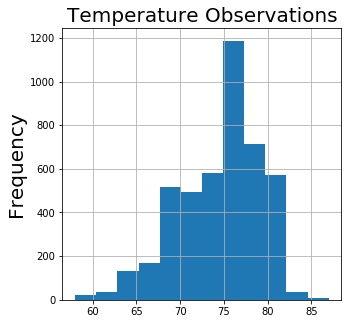

In [13]:
#Past 12 months data
df_last_12 = pd.DataFrame(last_12_months, columns=['Station', 'temp', 'date'])
df_last_12.set_index('Station', inplace=True)
hist_plot = df_last_12['temp'].hist(bins=12, figsize=(5,5))
hist_plot.set_title('Temperature Observations', fontsize=20)
hist_plot.set_ylabel('Frequency', fontsize=20)
plt.show()

In [14]:
def calc_temps():
    start_date = input("Enter the start date in the form of YYYY-MM-DD no later than 2017-08-23: ")
    end_date = input("Enter the end date in the form of YYYY-MM-DD no later than 2017-08-23: ")
    temp_range = session_HM.query(func.max(HM.tobs),func.min(HM.tobs),func.avg(HM.tobs))\
                .filter(HM.date >= start_date ).filter(HM.date <= end_date).all()
    return temp_range
temperatures = calc_temps()
temperatures

Enter the start date in the form of YYYY-MM-DD no later than 2017-08-23: 2016-08-23
Enter the end date in the form of YYYY-MM-DD no later than 2017-08-23: 2017-08-23


[(87.0, 58.0, 74.59058295964125)]

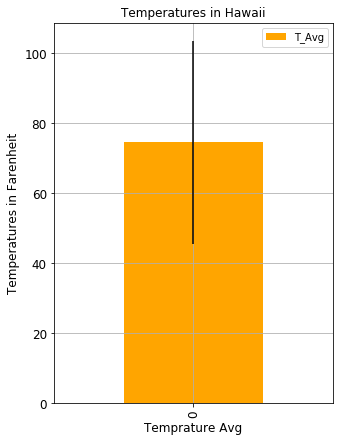

In [112]:
labels = ['T_Max','T_Min','T_Avg']
df_bar = pd.DataFrame.from_records(temperatures, columns=labels)
yerr = df_bar[['T_Max']].values-df_bar[['T_Min']].values
temp_chart = df_bar[['T_Avg']].plot(kind='bar', title ="Temperatures in Hawaii", figsize=(5, 7),\
                                    legend=True, fontsize=12, grid=True, color='orange',yerr = yerr)
# plt.plot(1,df_bar[['T_Avg']],yerr = yerr)
temp_chart.set_xlabel("Temprature Avg", fontsize=12)
temp_chart.set_ylabel("Temperatures in Farenheit", fontsize=12)
plt.show()


In [84]:
from flask import Flask, jsonify


In [95]:
start = input("Enter a value for date in the form YYYY-MM-DD: ")
start_array = session_HM.query(func.max(HM.tobs),func.min(HM.tobs),func.avg(HM.tobs))\
                .filter(HM.date >= start).all()
start_list = list(np.ravel(start_array))



Enter a value for date in the form YYYY-MM-DD: 2016-08-01


{'T_AVG': 74.803541315345697, 'T_MAX': 87.0, 'T_MIN': 58.0}

In [99]:
app = Flask(__name__)

@app.route("/")
def welcome():
    """List all available api routes."""
    return (
        "/api/v1.0/precipitation<br/>"
        "/api/v1.0/stations<br/>"
        "/api/v1.0/tobs<br/>"
        "/api/v1.0/start<br/> "
        "/api/v1.0/<start> " + "and " + "/api/v1.0/<start>/<end><br/>"
    )


@app.route("/api/v1.0/precipitation")
def prcp():
    prcp_array = session_HM.query(HM.date,HM.prcp)\
                .filter(HM.date >= '2016-01-01' ).filter(HM.date <= '2017-01-01').all()
    prcp_list = list(np.ravel(prcp_array))
    
    for i in range(len(prcp_list)):
        if i%2 ==0:
            prcp_list[i] = prcp_list[i].strftime('%Y-%m-%d')
    
    keys = []
    values = []
    
    for i in range(len(prcp_list)):
        if i%2 == 0:
            keys.append(prcp_list[i])
        else:
            values.append(prcp_list[i])
    prcp_dict = dict(zip(keys,values))
    
    return jsonify(prcp_dict)


@app.route("/api/v1.0/stations")
def stations():
    stations_array = session_HM.query(HM.station).all()
    stations_list = list(np.ravel(stations_array))

    return jsonify(stations_list)

@app.route("/api/v1.0/tobs")
def tobs():
    tobs_array = session_HM.query(HM.tobs)\
                .filter(HM.date >= '2016-01-01' ).filter(HM.date <= '2017-01-01').all()
    tobs_list = list(np.ravel(tobs_array))

    return jsonify(tobs_list)


@app.route("/api/v1.0/start")
def dates():
    start = input("Enter a value for date in the form YYYY-MM-DD: ")
    start_array = session_HM.query(func.max(HM.tobs),func.min(HM.tobs),func.avg(HM.tobs))\
                .filter(HM.date >= start).all()
    start_list = list(np.ravel(start_array))
    T_info = {"T_MAX":start_list[0],"T_MIN":start_list[1],"T_AVG":start_list[2]}

    return jsonify(T_info)


@app.route("/api/v1.0/start/end")
def dates_end():
    start = input("Enter a value for start date in the form YYYY-MM-DD: ")
    end = input("Enter a value for end date in the form YYYY-MM-DD: ")
    start_end_array = session_HM.query(func.max(HM.tobs),func.min(HM.tobs),func.avg(HM.tobs))\
                .filter(HM.date >= start).filter(HM.date <= end).all()
    start_end_list = list(np.ravel(start_end_array))
    T_info_end = {"T_MAX":start_end_list[0],"T_MIN":start_end_list[1],"T_AVG":start_end_list[2]}
    
    return jsonify(T_info_end)


if __name__ == "__main__":
    app.run()


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [17/Apr/2018 20:59:39] "GET / HTTP/1.1" 200 -


Enter a value for date in the form YYYY-MM-DD: s


127.0.0.1 - - [17/Apr/2018 20:59:58] "GET /api/v1.0/start HTTP/1.1" 200 -
